# The Eckmann–Hilton argument

A nice theoretical feature of `rewalt` is "topological soundness": a diagrammatic set can be *geometrically realised* as a CW complex with one cell for each of its generators, and every diagram that we construct in the diagrammatic set corresponds to a valid homotopy in its realisation.

One of the first non-trivial homotopies that one encounters in algebraic topology are the "braiding" homotopies between two 2-cells, exhibiting the fact that $\pi_2$ of a space is always an *abelian* group. The construction of these homotopies is known as *Eckmann–Hilton argument*, and is also the basis of the identification of [braided monoidal categories with "doubly degenerate" tricategories](https://arxiv.org/abs/0706.2307).

In this notebook, we will implement the Eckmann–Hilton argument in `rewalt`, by constructing both homotopies in a diagrammatic set with a single 0-dimensional generator and two 2-dimensional generators. Thanks to topological soundness, you can also see this as a *formal proof* of the usual homotopical Eckmann–Hilton.

First of all, let's create a diagrammatic set, and add all the generators. We will colour-code the two 2-cells, one in blue and one in magenta.

In [1]:
import rewalt

# the next line is only to avoid a jupyter warning; you can ignore it
rewalt.strdiags.DEFAULT['show'] = False

EH = rewalt.DiagSet()
pt = EH.add('pt', draw_label=False)
a = EH.add('a', pt.unit(), pt.unit(), color='blue')
b = EH.add('b', pt.unit(), pt.unit(), color='magenta')

## First braiding

The "braiding homotopies" will be made of degenerate cells, starting from the pasting "`b` after `a`", and ending in the pasting "`a` after `b`".

Our construction of these homotopies will be, essentially, an implementation of the ["train tracks" proof by André Joyal and Joachim Kock](https://arxiv.org/abs/math/0602084). Let's start from the beginning.

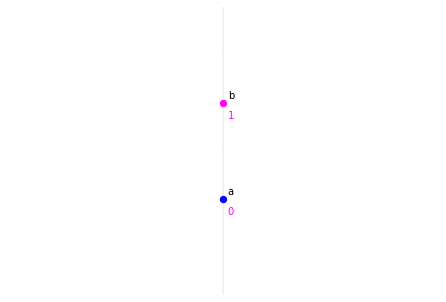

In [2]:
start = a.paste(b)
start.draw(nodepositions=True)

Let's introduce some weak units between `a` and `b`; one would be sufficient, but we'll do two for reasons of symmetry.

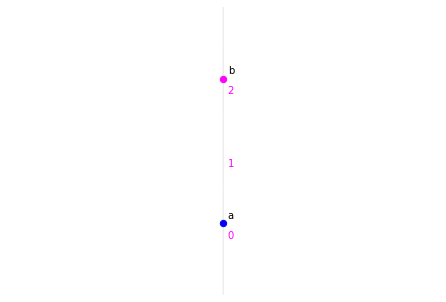

In [3]:
rew1 = start.rewrite(0, a.runitor('+'))
rew1.output.draw(nodepositions=True)

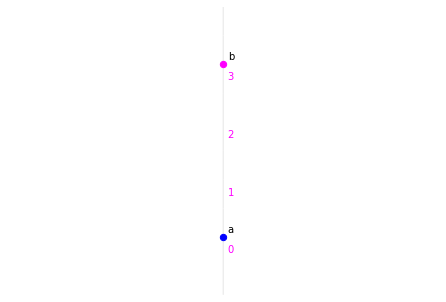

In [4]:
rew2 = rew1.output.rewrite(2, b.lunitor('+'))
rew2.output.draw(nodepositions=True)

Now, we want to "split" the units in positions (1, 2) into two "train tracks". This can be done with a "fully degenerate" cell over `pt`, of the appropriate shape:

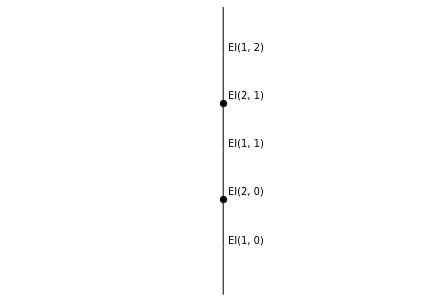

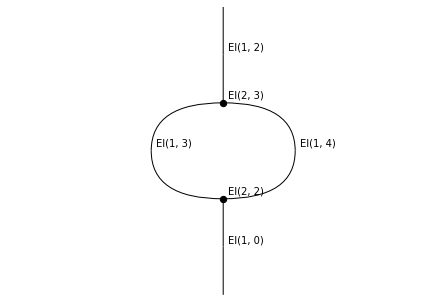

In [5]:
globe = rewalt.Shape.globe(2)
triangle = rewalt.Shape.simplex(2)

track_split_shape = globe.paste(globe).atom(triangle.paste(triangle.dual()))
track_split_shape.draw_boundaries()

You can see that `track_split_shape` is a 3-dimensional shape with input and output of the shape we desire, going from "single track" (pasting of two 2-globes) to "double track" (pasting of a 2-simplex with its dual).

To get a "fully degenerate" cell over `pt` of shape `track_split_shape`, we use the `degeneracy` method.

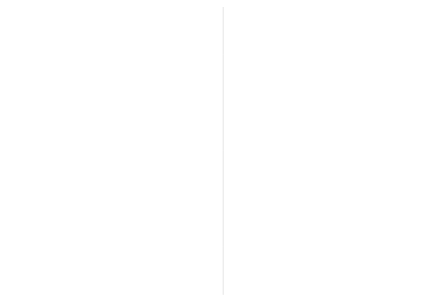

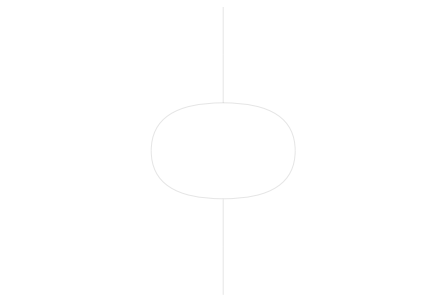

In [6]:
track_split = pt.degeneracy(track_split_shape)
track_split.draw_boundaries()

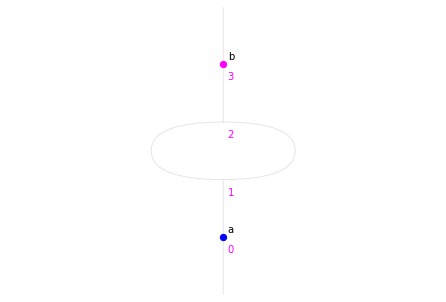

In [7]:
rew3 = rew2.output.rewrite([1, 2], track_split)
rew3.output.draw(nodepositions=True)

Now, our goal is to "move `a` to the right track, and move `b` to the left track". This can be done with appropriate degenerate cells over `a` and `b`.

These degenerate cells are neither units or unitors. However, just like units and unitors, they can be obtained from pullbacks of `a` and `b` over particular collapse maps from a "partially collapsed cylinder" on their shape, as provided by the `inflate` method of the `Shape` class.

(I do not expect that this is particulary intuitive; you should try fiddling with `inflate` to get an idea of the collapses you can get.)

This, for example, is the map we can use to move `a` from the bottom to the right track.

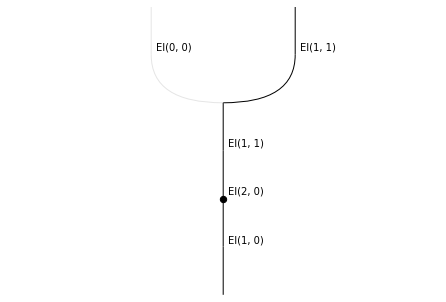

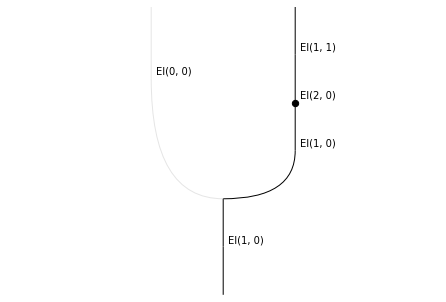

In [8]:
switch_br_map = globe.inflate(globe.all().boundary('+', 0))
switch_br_map.draw_boundaries()

Every other "switch" map we will get as a *dual* of this one. For example, the "top-to-left" that we need for `b` is the dual in dimensions 1 and 2 ("horizontal and vertical flip").

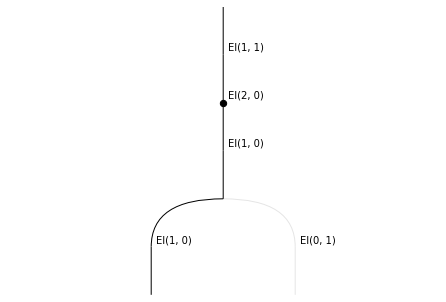

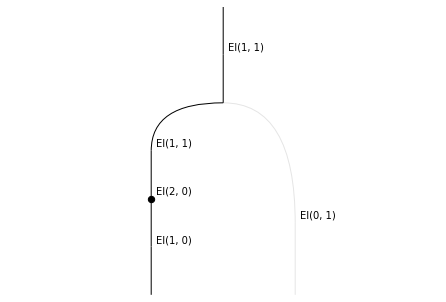

In [9]:
switch_tl_map = switch_br_map.dual(1, 2)
switch_tl_map.draw_boundaries()

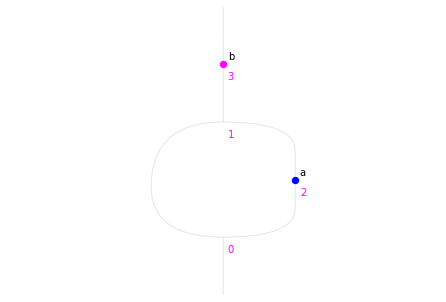

In [10]:
a_switch_br = a.pullback(switch_br_map)

rew4 = rew3.output.rewrite([0, 1], a_switch_br)
rew4.output.draw(nodepositions=True)

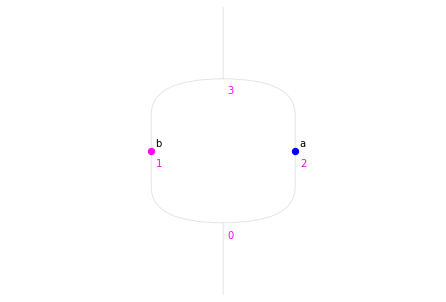

In [11]:
b_switch_tl = b.pullback(switch_tl_map)

rew5 = rew4.output.rewrite([1, 3], b_switch_tl)
rew5.output.draw(nodepositions=True)

Now we will move `a` to the top, then `b` to the bottom. For that, we use pullbacks along other duals of our original "switch" map.

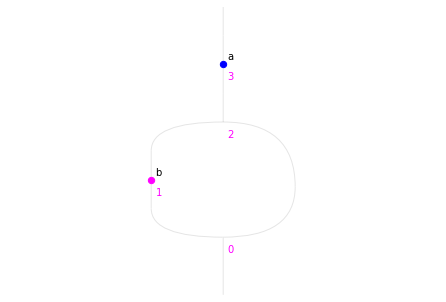

In [12]:
switch_rt_map = switch_br_map.dual(2, 3)
a_switch_rt = a.pullback(switch_rt_map)

rew6 = rew5.output.rewrite([2, 3], a_switch_rt)
rew6.output.draw(nodepositions=True)

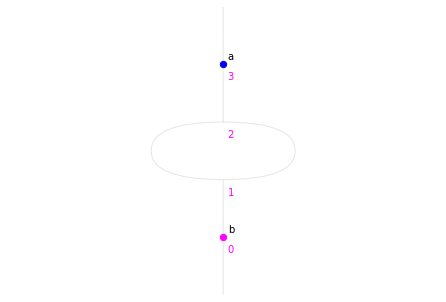

In [13]:
switch_lb_map = switch_br_map.dual(1, 3)
b_switch_lb = b.pullback(switch_lb_map)

rew7 = rew6.output.rewrite([0, 1], b_switch_lb)
rew7.output.draw(nodepositions=True)

The relative positions of `a` and `b` have been exchanged! Now we only need to get rid of the "train tracks" and other units between them.

We used degenerate cells to introduce them, and degenerate cells are always "weakly invertible", so we can just use their "weak inverses", obtained with the `inverse` method.

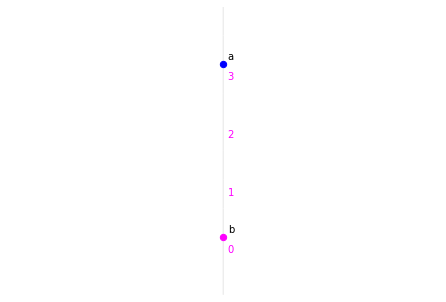

In [14]:
rew8 = rew7.output.rewrite([1, 2], track_split.inverse)
rew8.output.draw(nodepositions=True)

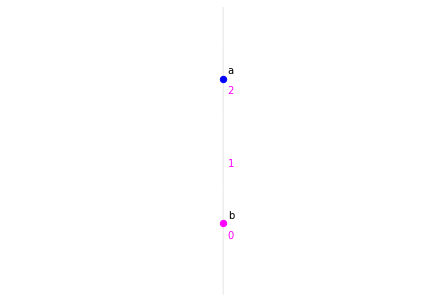

In [15]:
rew9 = rew8.output.rewrite([0, 1], b.runitor('-'))
rew9.output.draw(nodepositions=True)

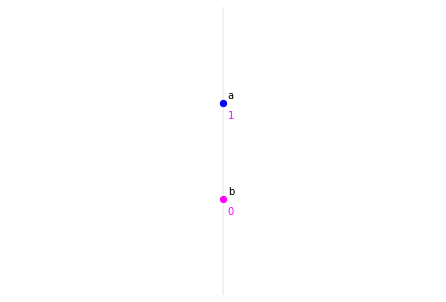

In [16]:
rew10 = rew9.output.rewrite([1, 2], a.lunitor('-'))
rew10.output.draw(nodepositions=True)

We are done! Let's put all our rewrites together, and see what our proof looks like as a slice of a 3-dimensional diagram.

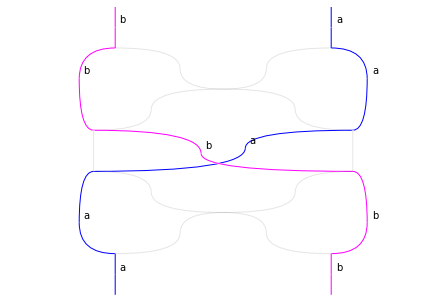

In [17]:
eh1 = rewalt.Diagram.with_layers(
    rew1, rew2, rew3, rew4, rew5, rew6, rew7, rew8, rew9, rew10)
eh1.draw()

See? It's a braiding where the `b` strand is passing over the `a` strand.

We can also assemble all our rewrites into a gif animation. We will also make it loop backwards.

In [18]:
rewalt.strdiags.to_gif(
    *eh1.rewrite_steps, degenalpha=0.2,
    loop=True, path='eckmannhilton_1.gif')

![EckmannHilton1](eckmannhilton_1.gif 'An Eckmann-Hilton braiding, as a sequence of rewrite steps')

## Second braiding

In our proof, we made the choice of moving `a` onto the right track, and `b` onto the left track; but we might as well have made a different choice. This would have led to a non-equivalent homotopy, the *dual* braiding.

Let's go back to the step where we had the choice, and make a different one. 
This corresponds to "horizontally flipping" all the maps we used the first time.

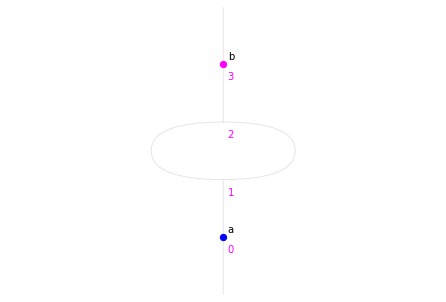

In [19]:
rew3.output.draw(nodepositions=True)

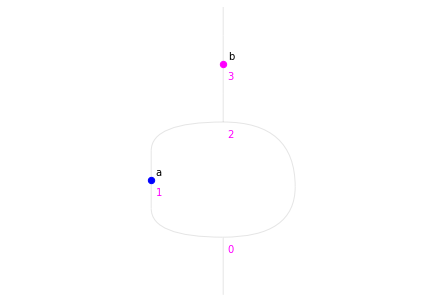

In [20]:
switch_bl_map = switch_br_map.dual(1)
a_switch_bl = a.pullback(switch_bl_map)

rew4d = rew3.output.rewrite([0, 1], a_switch_bl)
rew4d.output.draw(nodepositions=True)

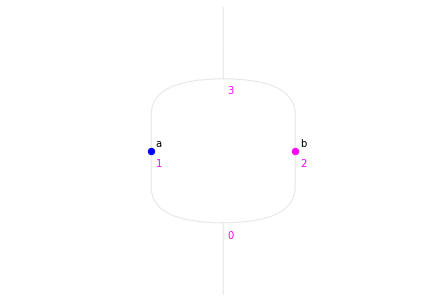

In [21]:
switch_tr_map = switch_tl_map.dual(1)
b_switch_tr = b.pullback(switch_tr_map)

rew5d = rew4d.output.rewrite([2, 3], b_switch_tr)
rew5d.output.draw(nodepositions=True)

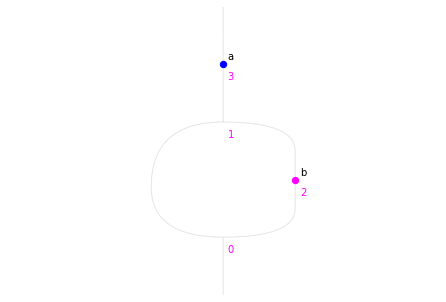

In [22]:
switch_lt_map = switch_rt_map.dual(1)
a_switch_lt = a.pullback(switch_lt_map)

rew6d = rew5d.output.rewrite([1, 3], a_switch_lt)
rew6d.output.draw(nodepositions=True)

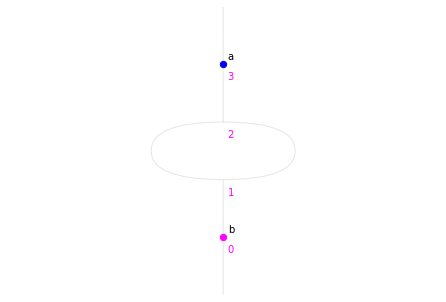

In [23]:
switch_rb_map = switch_lb_map.dual(1)
b_switch_rb = b.pullback(switch_rb_map)

rew7d = rew6d.output.rewrite([0, 2], b_switch_rb)
rew7d.output.draw(nodepositions=True)

That's it; the last few steps are the same as the first time. Let's put the whole sequence together.

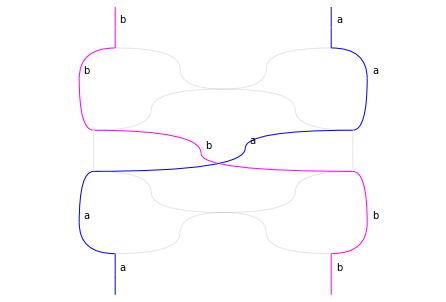

In [24]:
eh2 = rewalt.Diagram.with_layers(
    rew1, rew2, rew3, rew4d, rew5d, rew6d, rew7d, rew8, rew9, rew10)
eh2.draw()

See? Now it is the blue (`a`) strand that crosses over the magenta (`b`) strand.

And let's make another animation.

In [25]:
rewalt.strdiags.to_gif(
    *eh2.rewrite_steps, degenalpha=0.2,
    loop=True, path='eckmannhilton_2.gif')

![EckmannHilton2](eckmannhilton_2.gif 'Another Eckmann-Hilton braiding, as a sequence of rewrite steps')

The diagrams `eh1` and `eh2` have the same input and output; they could, in principle, be the input and output of another cell. 

By topological soundness, however, we know that there *isn't* a diagram between `eh1` and `eh2`: the geometric realisation of `EH` is a bouquet of two 2-spheres, and in this space there isn't a homotopy between the two "braidings".

You are welcome to add one by hand, if you really want.

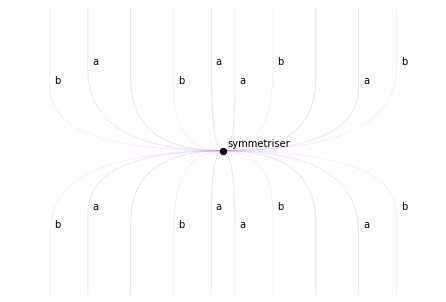

In [26]:
symmetriser = EH.add('symmetriser', eh1, eh2)
symmetriser.draw()